# Image caption runs with various hyperparameters

### Run for <span style="color:red;">1800</span>s

In [1]:
%matplotlib inline
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import subprocess
import os
import seaborn as sns

In [2]:
!ls logs/fixtime/

SGD             time_limit1800s


In [3]:
logdir = "logs/fixtime/time_limit1800s"

In [4]:
filename_pattern=re.compile(r"imagecaption_.*\.log")
files=[]
comm = "ls -1 "+logdir
proc = subprocess.Popen(comm.split(" "),
                     stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
for line in iter(proc.stdout.readline,b''):
    m = filename_pattern.match(line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir,line)))
len(files)

182

In [5]:
batch_learn_pattern = re.compile(r"_b(\d+)_l([0-9\.]+)_smp\d+_(\d+)") # Match against file name
output_pattern = re.compile(r"^(\d+),\s*([0-9\.]+),\s*([0-9\.]+)")
validation_pattern = re.compile(r"^{'Bleu_1':\s*([0-9e\-\.]+),\s*'Bleu_2':\s*([0-9e\-\.]+),\s*'Bleu_3':\s*([0-9e\-\.]+),\s*'Bleu_4':\s*([0-9e\-\.]+),\s*'ROUGE_L':\s*([0-9e\-\.]+),\s*'CIDEr':\s*([0-9e\-\.]+)}")

# Read minibatch size and 1st epoch time from files.
# Store in a DataFrame.
def fileToDF(logfile, debug=False):
    global output_pattern, batch_learn_pattern, validation_pattern
    
    logfile = logfile.strip(" \n")
    filename = os.path.basename(logfile)
    if debug: print "FILE",filename
    batch = 0
    learn = 0
    run = 0
    m = batch_learn_pattern.search(filename)
    if m:
        batch = int(m.group(1))
        learn = float(m.group(2))
        run = int(m.group(3))
        if debug: print "BS,LR,run:",batch,learn,run
    
    with open(logfile,"r") as f:
        lines = f.readlines()
        time = 0
        epoch = 0
        ind = 0
        ind_v = 0 # DataFrame row number (index) for df_validation
        df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                       "epoch","time","loss"])
        df_validation = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
        for line in lines:
            s = line.strip(' \n')            
            m2 = output_pattern.match(s)
            if m2:
                # Use only last line from file (with max epoch counter)
                if debug: print line,                    
                epoch = int(m2.group(1))
                time += float(m2.group(2))  # Time per epoch must be summed
                loss = float(m2.group(3))
                if debug: print "BS,LR,run,epoch,time,loss:",batch,learn,run,epoch,time,loss
                df_epochtime.loc[ind] = [batch,learn,run,epoch,time,loss]
                ind += 1
            else:
                m3 = validation_pattern.match(s)
                if m3:
                    if debug: print line,
                    bl1 = float(m3.group(1))
                    bl2 = float(m3.group(2))
                    bl3 = float(m3.group(3))
                    bl4 = float(m3.group(4))
                    rouge = float(m3.group(5))
                    cider = float(m3.group(6))
                    if debug: print "Bleu, Rouge, CIDEr:",bl1,bl2,bl3,bl4,rouge,cider
                    df_validation.loc[ind_v] = [batch,learn,run,
                                                bl1,bl2,bl3,bl4,
                                                rouge, cider]
                    ind_v += 1

    return (df_epochtime, df_validation)

In [6]:
def readLogs(logdir, debug=False, maxfiles=10000000):
    global filename_pattern
    files=[]
    comm = "ls -1 "+logdir
    proc = subprocess.Popen(comm.split(" "),
                         stdout=subprocess.PIPE,stderr=subprocess.STDOUT)
    for line in iter(proc.stdout.readline,b''):
        m = filename_pattern.match(line)
        if m:
            files.append(os.path.abspath(os.path.join(logdir,line)))
            
    #if debug: print "files:",files
    df_epochtime = pd.DataFrame(data=None,columns=["batch","lr","run","epoch","time","loss"])
    df_validation = pd.DataFrame(data=None,columns=["batch","lr","run",
                                                        "bleu1","bleu2","bleu3","bleu4",
                                                        "rouge","cider"])
    filecounter=0
    for file in files:
        if debug: print file
        df_e1,df_v1 = fileToDF(file,debug)
        if len(df_e1) > 0:
            df_epochtime = pd.concat([df_epochtime,df_e1],ignore_index=True)
        if len(df_v1) > 0:
            df_validation = pd.concat([df_validation,df_v1],ignore_index=True)
        filecounter +=1
        if filecounter>=maxfiles:
            return df
    return (df_epochtime, df_validation)

In [7]:
print logdir
df_epochtime,df_validation = readLogs(logdir)
print df_validation.shape, df_epochtime.shape

logs/fixtime/time_limit1800s
(182, 9) (27483, 6)


In [8]:
df_validation[["batch","run"]] = df_validation[["batch","run"]].astype(int)
df_epochtime[["batch","run"]] = df_epochtime[["batch","run"]].astype(int)
df_validation.head()

,batch,lr,run,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,12,0.0001,0,0.212399,0.122199,0.079269,0.053763,0.239460,0.141409
1,12,0.0001,1,0.187402,0.112553,0.073595,0.050095,0.228863,0.122010
2,12,0.0005,0,0.509377,0.362138,0.265413,0.191779,0.406360,0.240103
3,12,0.0005,1,0.539671,0.395964,0.296946,0.223133,0.438080,0.282516
4,12,0.0010,0,0.469321,0.337685,0.254942,0.190326,0.391646,0.236562


## Validation score

In [9]:
print df_validation.shape
df_validation.head()

(182, 9)


,batch,lr,run,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,12,0.0001,0,0.212399,0.122199,0.079269,0.053763,0.239460,0.141409
1,12,0.0001,1,0.187402,0.112553,0.073595,0.050095,0.228863,0.122010
2,12,0.0005,0,0.509377,0.362138,0.265413,0.191779,0.406360,0.240103
3,12,0.0005,1,0.539671,0.395964,0.296946,0.223133,0.438080,0.282516
4,12,0.0010,0,0.469321,0.337685,0.254942,0.190326,0.391646,0.236562


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x113649910>]],
      dtype=object)

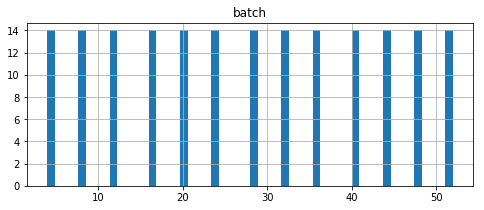

In [10]:
# Checking number of rows in the dataframe per batch size
# 7 LR values x 2 runs = 14 rows
plt.rcParams['figure.figsize'] = 8,3
df_validation[["batch"]].hist(bins=52)

In [11]:
# Take average between runs
df_mean = df_validation.groupby(["batch","lr"]).mean().reset_index().drop(["run"],axis=1)
df_mean.head()

,batch,lr,bleu1,bleu2,bleu3,bleu4,rouge,cider
0,4,0.0001,0.250210,0.164065,0.116908,0.084096,0.308043,0.137066
1,4,0.0005,0.467907,0.335402,0.257792,0.196554,0.405860,0.212333
2,4,0.0010,0.371765,0.258210,0.187029,0.139041,0.342159,0.142389
3,4,0.0025,0.312394,0.205195,0.143212,0.103702,0.316500,0.090970
4,4,0.0050,0.025190,0.006776,0.004621,0.003257,0.145982,0.012201


In [12]:
df_cider = df_mean.pivot_table(index="batch",columns="lr",values="cider")
df_rouge = df_mean.pivot_table(index="batch",columns="lr",values="rouge")
df_bleu1 = df_mean.pivot_table(index="batch",columns="lr",values="bleu1")
df_bleu2 = df_mean.pivot_table(index="batch",columns="lr",values="bleu2")
df_bleu3 = df_mean.pivot_table(index="batch",columns="lr",values="bleu3")
df_bleu4 = df_mean.pivot_table(index="batch",columns="lr",values="bleu4")
df_cider.head()

lr,0.0001,0.0005,0.001,0.0025,0.005,0.0075,0.01
batch,,,,,,,
4,0.137066,0.212333,0.142389,0.090970,0.012201,0.001362,0.000045
8,0.168773,0.274237,0.245892,0.139492,0.088484,0.035020,0.003472
12,0.131710,0.261310,0.262204,0.175772,0.106882,0.031115,0.024800
16,0.140026,0.292750,0.263061,0.198696,0.117753,0.031969,0.037911
20,0.145452,0.274244,0.266769,0.216239,0.116426,0.067459,0.015987


In [13]:
def plotHeatMap(df,ax,title=None,cmap=None):        
    cmesh=ax.pcolormesh(df,cmap=cmap)
    fig.colorbar(mappable=cmesh,ax=ax)    
    ax.set_yticks(np.arange(0.5, len(df.index), 1))
    ax.set_yticklabels(df.index)
    ax.set_xticks(np.arange(0.5, len(df.columns), 1))
    ax.set_xticklabels(df.columns)
    ax.tick_params(direction='in', length=0)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if df.iloc[y,x] > 0:
                ax.text(x+0.5,y+0.5,'{:.3f}'.format(df.iloc[y,x]),
                         color="black",fontsize=9,
                         horizontalalignment='center',
                         verticalalignment='center',                    
                         bbox={'facecolor':'white','edgecolor':'none', 'alpha':0.3, 'pad':0})
    ax.set_title(title,fontsize=18)

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


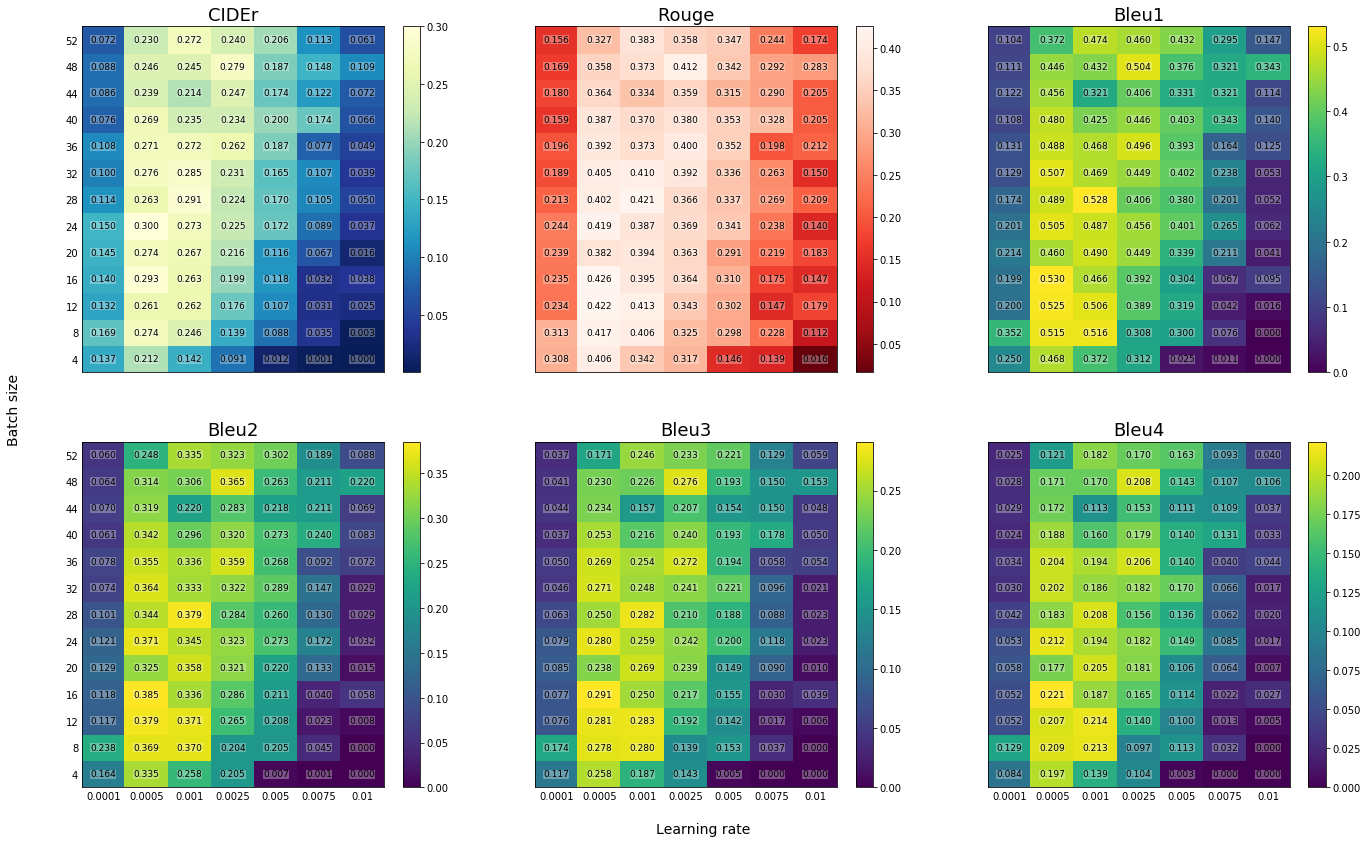

In [14]:
plt.rcParams['figure.figsize'] = 23,14
fig, ax = plt.subplots(2,3,sharex=True,sharey=True)
plotHeatMap(df_cider,ax[0,0],"CIDEr","YlGnBu_r")
plotHeatMap(df_rouge,ax[0,1],"Rouge","Reds_r")
plotHeatMap(df_bleu1,ax[0,2],"Bleu1")
plotHeatMap(df_bleu2,ax[1,0],"Bleu2")
plotHeatMap(df_bleu3,ax[1,1],"Bleu3")
plotHeatMap(df_bleu4,ax[1,2],"Bleu4")
fig.text(0.5, 0.08, 'Learning rate', ha='center',fontsize=14)
fig.text(0.08, 0.5, 'Batch size', va='center', rotation='vertical',fontsize=14)
fig.show()

## Loss and time

In [20]:
# Leave only max epoch rows
df_epochtime[(df_epochtime["batch"]==28) & (df_epochtime["lr"] == 0.0025) & (df_epochtime["run"] == 0) ].tail()
# time is too large?

,batch,lr,run,epoch,time,loss
9662,28,0.0025,0,113.0,1761.025255,5.862545
9663,28,0.0025,0,114.0,1774.256535,5.620193
9664,28,0.0025,0,115.0,1785.282491,5.636684
9665,28,0.0025,0,116.0,1796.321339,5.742163
9666,28,0.0025,0,117.0,1807.362358,5.557936


In [21]:
# Loss is not always at minimum at last epoch,
# so aggragation min(loss) doesn't show loss at last epoch
# though this approach also may have sence
df_maxepoch = df_epochtime.groupby(["batch","lr","run"]).agg({"epoch":"max","time":"max","loss":"min"})
df_maxepoch.head()

loss  epoch         time
batch lr     run                              
4     0.0001 0    5.429895   97.0  1816.646682
             1    5.191651   95.0  1808.248597
      0.0005 0    5.117315   95.0  1805.208671
             1    5.432629   95.0  1810.289792
      0.0010 0    5.466829   96.0  1803.643617

In [22]:
# Make new column with max epoch for each (batch, lr, run) combination
df_maxepoch = df_epochtime.copy()
df_maxepoch["max_epoch"] = df_epochtime.groupby(["batch","lr","run"])["epoch"].transform(np.max)
df_maxepoch = df_maxepoch.sort_values(by=["batch","lr","run"],ascending=True)
df_maxepoch.head()

,batch,lr,run,epoch,time,loss,max_epoch
22128,4,0.0001,0,1.0,19.016519,6.992029,97.0
22129,4,0.0001,0,2.0,37.573115,7.210260,97.0
22130,4,0.0001,0,3.0,56.647552,6.696153,97.0
22131,4,0.0001,0,4.0,75.462004,6.691007,97.0
22132,4,0.0001,0,5.0,94.303820,6.842924,97.0


In [23]:
df_maxepoch = df_maxepoch[df_maxepoch["max_epoch"] == df_maxepoch["epoch"]]
df_maxepoch.head()

,batch,lr,run,epoch,time,loss,max_epoch
22224,4,0.0001,0,97.0,1816.646682,5.843218,97.0
22319,4,0.0001,1,95.0,1808.248597,5.623983,95.0
22414,4,0.0005,0,95.0,1805.208671,5.863252,95.0
22509,4,0.0005,1,95.0,1810.289792,5.905297,95.0
22605,4,0.0010,0,96.0,1803.643617,5.529968,96.0


In [24]:
df_maxepoch[(df_maxepoch["batch"]==28) & (df_maxepoch["lr"] == 0.0025)]

,batch,lr,run,epoch,time,loss,max_epoch
9666,28,0.0025,0,117.0,1807.362358,5.557936,117.0
9829,28,0.0025,1,163.0,1810.856012,5.564502,163.0


In [25]:
# Drop row 9666: this session worked much slower than average, may be there were interference.
print df_maxepoch.shape
df_maxepoch = df_maxepoch.drop([9666])
print df_maxepoch.shape

(182, 7)
(181, 7)


In [26]:
# Take average between runs
df_mean = df_maxepoch.groupby(["batch","lr"]).mean().reset_index().drop(["run","max_epoch","time"],axis=1)
df_mean.head()

,batch,lr,epoch,loss
0,4,0.0001,96.0,5.733600
1,4,0.0005,95.0,5.884275
2,4,0.0010,96.0,5.571224
3,4,0.0025,97.0,6.349467
4,4,0.0050,96.0,6.788412


In [27]:
loss_df = df_mean[['batch','lr','loss']]
epoch_df = df_mean[['batch','lr','epoch']]

In [28]:
def getColorList(cmap,n):
    cmap = cm.get_cmap(cmap, n)
    colors = []
    for i in range(cmap.N):
        c = matplotlib.colors.to_hex(cmap(i),keep_alpha=True)
        colors.append(c)
    return colors

[u'#1e0000ff', u'#6e4545ff', u'#986262ff', u'#b97878ff', u'#ca9a8bff', u'#d6bb9bff', u'#e1d7aaff', u'#ebebbfff', u'#fdc38dff', u'#fca16cff', u'#f67b51ff', u'#e7533aff', u'#cf2518ff']


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


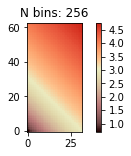

In [29]:
# Combine colormaps
colors1 = getColorList("pink",10)
colors2 = getColorList("OrRd",10)
colors =  colors1[:8] + colors2[3:8]
print colors
n_bin = 256
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=n_bin)
# Fewer bins will result in "coarser" colomap interpolation
x = np.arange(0, np.pi, 0.1)
y = np.arange(0, 2*np.pi, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.log((X+Y+1)*(X+Y+2))

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = [u'Avenir Next Condensed']
plt.rcParams['figure.figsize'] = 5,2
fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='nearest', origin='lower', cmap=cmap)
ax.set_title("N bins: %s" % n_bin)
fig.colorbar(im, ax=ax)

colors: [u'#24368Eff', u'#5BBEC0ff', u'#F4FAC4ff']
[u'Avenir Next Condensed']


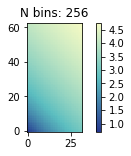

In [31]:
# Create custom colormap
colors= [u'#24368Eff',
         u'#5BBEC0ff',
         u'#F4FAC4ff']
plt.rcParams['figure.figsize'] = 5,2
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=n_bin)
# Fewer bins will result in "coarser" colomap interpolation

x = np.arange(0, np.pi, 0.1)
y = np.arange(0, 2*np.pi, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.log((X+Y+1)*(X+Y+2))
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = [u'Avenir Next Condensed']
fig, ax = plt.subplots()
im = ax.imshow(Z, interpolation='nearest', origin='lower', cmap=cmap)
ax.set_title("N bins: %s" % n_bin)
fig.colorbar(im, ax=ax)

print "colors:",colors
print matplotlib.rcParams["font.sans-serif"]


In [32]:
def plotHeatMap(df,title=None,cmap=None):
    plt.rcParams['figure.figsize'] = 10,8
    
    if isinstance(cmap,list):
        colors_num = np.ceil(256/len(cmap))
        for org_cmap in cmap:
            colors = cm.get_cmap(org_cmap,colors_num)
            
    plt.pcolormesh(df,cmap=cmap)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    ax = plt.gca()
    ax.tick_params(direction='in', length=0)
    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            if df.iloc[y,x] > 0:
                plt.text(x+0.5,y+0.5,'{:.3f}'.format(df.iloc[y,x]),
                         color="black",fontsize=9,
                         horizontalalignment='center',
                         verticalalignment='center',                    
                         bbox={'facecolor':'white','edgecolor':'none', 'alpha':0.2, 'pad':0})
    plt.title(title,fontsize=18)
    plt.xlabel("learning rate",fontsize=12)
    plt.ylabel("minibatch size",fontsize=12)
    plt.colorbar()
    plt.show()

In [33]:
loss_T = loss_df.pivot_table(index="batch",columns="lr",values="loss")
epoch_T = epoch_df.pivot_table(index="batch",columns="lr",values="epoch")

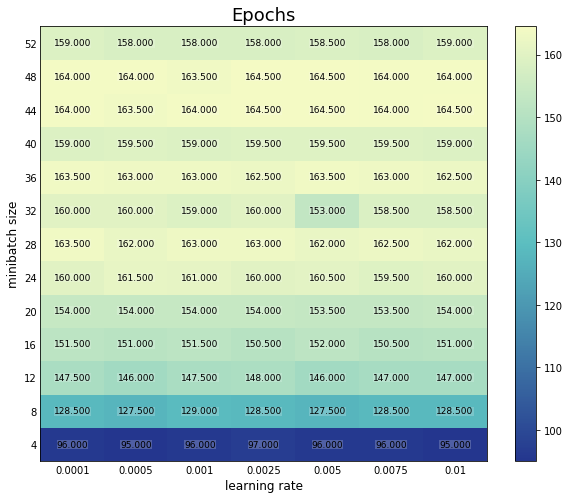

In [34]:
plotHeatMap(epoch_T,"Epochs",cmap)

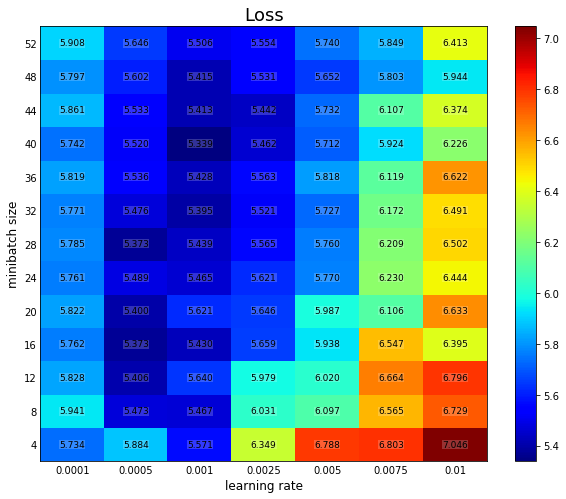

In [35]:
plotHeatMap(loss_T,"Loss","jet")

## Plot Loss graphs for each BS x LR combinations

In [37]:
df_epochtime[(df_epochtime["batch"] == 4.) & (df_epochtime["lr"] == 0.001) & (df_epochtime["epoch"] > 90)]

,batch,lr,run,epoch,time,loss
22600,4,0.001,0,91.0,1709.585275,5.697118
22601,4,0.001,0,92.0,1728.395002,5.784509
22602,4,0.001,0,93.0,1747.219628,6.204194
22603,4,0.001,0,94.0,1766.021897,5.602203
22604,4,0.001,0,95.0,1784.742121,5.564561
22605,4,0.001,0,96.0,1803.643617,5.529968
22696,4,0.001,1,91.0,1710.809186,6.131691
22697,4,0.001,1,92.0,1729.553532,5.848707
22698,4,0.001,1,93.0,1748.279173,6.208586
22699,4,0.001,1,94.0,1766.930692,5.434826


In [38]:
# Take average between runs
df_mean_epo = df_epochtime.groupby(["batch","lr","epoch"]).mean().reset_index().drop(["run"],axis=1)
df_mean_epo[(df_mean_epo["batch"] == 4.) & (df_mean_epo["lr"] == 0.001)].tail()

,batch,lr,epoch,time,loss
283,4,0.001,92.0,1728.974267,5.816608
284,4,0.001,93.0,1747.749400,6.206390
285,4,0.001,94.0,1766.476294,5.518515
286,4,0.001,95.0,1785.205148,5.790229
287,4,0.001,96.0,1803.992607,5.571224


In [39]:
df_mean_epo = df_mean_epo.sort_values(by=["batch"],ascending=False)
df_mean_epo = df_mean_epo.sort_values(by=["lr","epoch"],ascending=True)
print df_mean_epo["batch"].unique()
df_mean_epo.head(5)

[52 48 44 40 36 32 28 24 20 16 12  8  4]


,batch,lr,epoch,time,loss
12706,52,0.0001,1.0,11.973598,8.167537
11554,48,0.0001,1.0,11.663503,8.057498
10400,44,0.0001,1.0,11.726395,7.965438
9281,40,0.0001,1.0,12.031900,7.709759
8138,36,0.0001,1.0,11.377893,7.651155


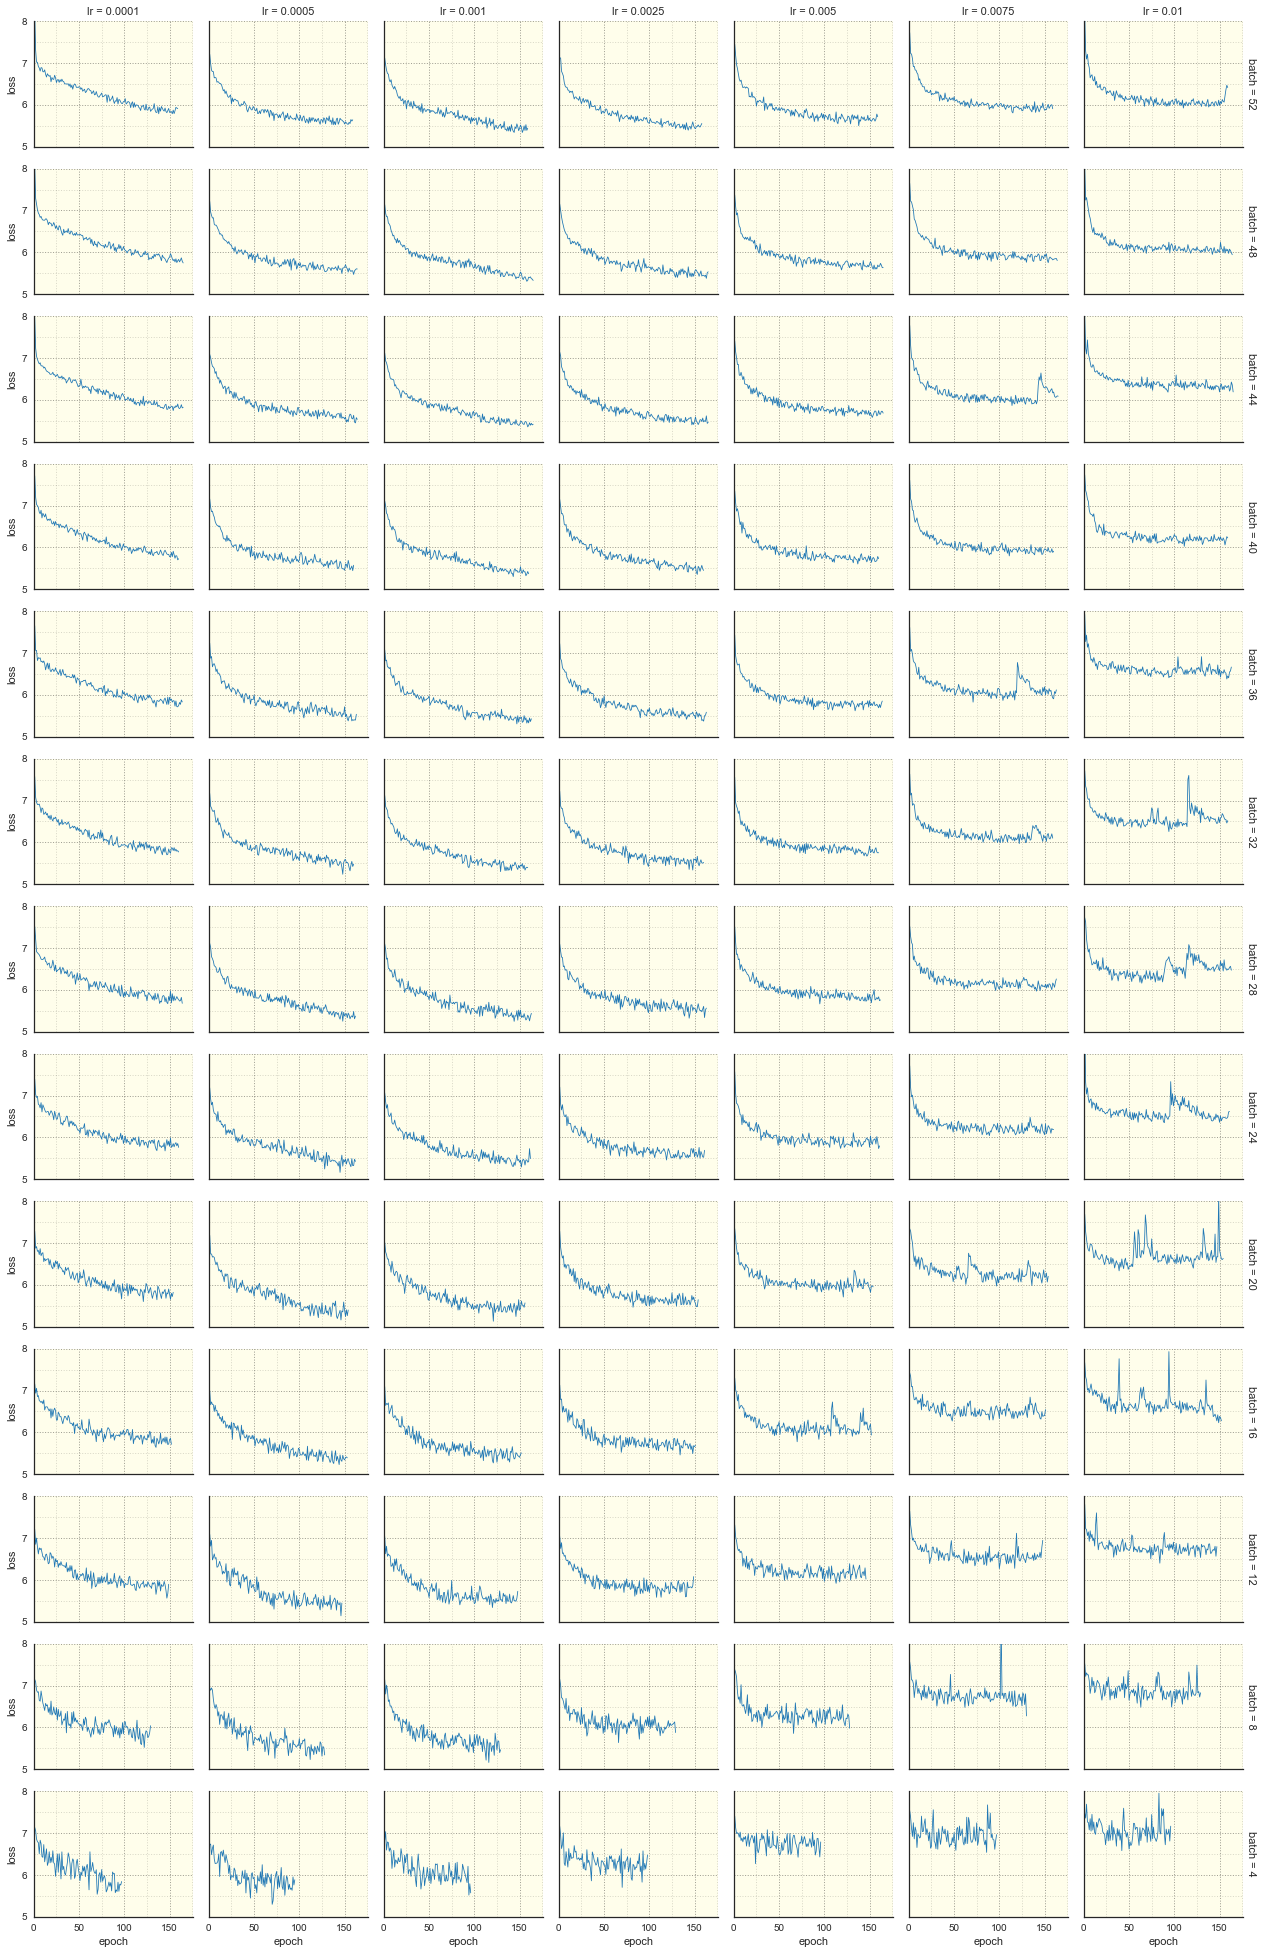

In [40]:
# Plot using Seaborn FacetGrid
# Set Seaborn global parameters
sns.set(font_scale=1)
#sns.set_style("white",{'axes.grid': True, 'grid.color': (0,0,0),'grid.linestyle':u':'})
sns.set_style("white")
#print sns.axes_style()

# Plot using "tab10" matplotlib colormap

major_xticks = np.arange(0,176,50)
minor_xticks = np.arange(0,176,25)
major_yticks = np.arange(5,8.1,1)
minor_yticks = np.arange(5,8.1,0.5)
with sns.color_palette("tab10"):
    fg = sns.FacetGrid(df_mean_epo,row="batch",col="lr",
                         row_order=df_mean_epo["batch"].unique(),
                         size=2.1,aspect=1.2,
                         #row_order=df_mean_epo.batch.unique(),
                         xlim=(0,176),
                         ylim=(5,8),
                         margin_titles=True,
                         subplot_kws={"facecolor":"#FFFEEB"})
    
    fg.map(plt.plot,"epoch","loss",ls="-",linewidth=.8)
    
    #print "FacetGrid:",fg.__dict__.keys()
    #print fg.axes.shape, fg.axes.size
    #axes = fg.axes.reshape(fg.axes.size)    
    for ax_arr in np.nditer(fg.axes,flags=["refs_ok"]):
        ax = ax_arr.item()
        ax.set_xticks(major_xticks)
        ax.set_yticks(major_yticks)
        ax.set_xticks(minor_xticks, minor=True)        
        ax.set_yticks(minor_yticks, minor=True)
        ax.grid(which="major",ls=":",alpha=0.25, color="black")
        ax.grid(which="minor",ls=":",alpha=0.15, color="black")

plt.show()